# Demonstrate examples for collaboration with novo nordisk

In [5]:
from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils
import torch.nn as nn

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Helper function for MMD
def mmd_rbf(x, y, sigma=1.0):
    """Compute MMD between two distributions using RBF kernel."""
    pairwise_sq_dists = squareform(pdist(np.vstack([x, y]), 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    K_xx = K[:len(x), :len(x)]
    K_xy = K[:len(x), len(x):]
    K_yy = K[len(x):, len(x):]
    mmd = np.mean(K_xx) - 2 * np.mean(K_xy) + np.mean(K_yy)
    return mmd


np.random.seed(42)

# nI = 3
# nX = 2
# nO = 2
# nS= 2
# p = nI+nX+nO+nS
# ate = 4
# beta_cov = 0
# strength_instr = 0
# strength_conf = 0
# strength_outcome = 1
# binary_intervention=True
nI = 2
nX = 0
nO = 2
nS= 2
p = nI+nX+nO+nS
ate = 2
beta_cov = 0
strength_instr = 0
strength_conf = 0
strength_outcome = 1
binary_intervention=True

In [6]:
df_tr = generate_data_causl(n=6000, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)
z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

# Original frengression

In [7]:
model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention)
model.train_xz(x_tr, z_tr, num_iters=5000, lr=1e-4, print_every_iter=1000)
model.train_y(x_tr, z_tr, y_tr, num_iters=4000, lr=1e-4, print_every_iter=1000,tol=0.001)

Epoch 1: loss 2.3020, loss1 2.4235, loss2 0.2430
Epoch 1000: loss 1.7099, loss1 3.3897, loss2 3.3596
Epoch 2000: loss 1.7030, loss1 3.3904, loss2 3.3748
Epoch 3000: loss 1.7124, loss1 3.3944, loss2 3.3642
Epoch 4000: loss 1.6935, loss1 3.3880, loss2 3.3890
Epoch 5000: loss 1.6959, loss1 3.3998, loss2 3.4079
Epoch 1: loss 2.2953,	loss_y 1.5365, 1.5504, 0.0279,	loss_eta 0.7589, 0.8046, 0.0915
Epoch 1000: loss 1.1403,	loss_y 0.5724, 1.1333, 1.1218,	loss_eta 0.5680, 1.1226, 1.1093
Stopping at iter 1782: |Δy|=-1.9825e-04, |Δη|=7.1883e-04


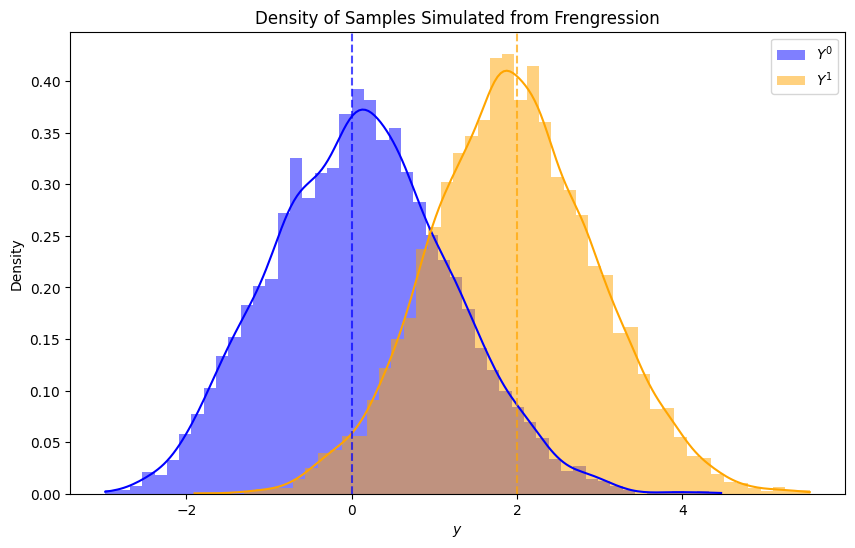

In [8]:
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=6000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=6000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(x=0, color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(x=2, color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density of Samples Simulated from Frengression")
plt.legend()
plt.show()


In [9]:
torch.save(model,"test.pt")
model=torch.load('test.pt')


In [10]:
class SpecifiedCausalMargin(nn.Module):
    def __init__(self, ate,x_dim):
        super().__init__()
        self.ate = ate  # or self.register_buffer('eta', torch.tensor(eta))
        self.x_dim = x_dim

    def forward(self, x_eta):
        # If 'eta' is truly separate, might need to handle that carefully
        x = x_eta[:, :self.x_dim]
        eta = x_eta[:, self.x_dim:]
        return self.ate * x + eta

In [11]:
margin_module = SpecifiedCausalMargin(ate=5, x_dim = x_tr.shape[1])
model.specify_causal(causal_margin=margin_module)
# model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=200)

sampled_x_5x,sampled_y_5x,sampled_z_5x = model.sample_joint(sample_size=5000)
print('Diff-in-means: ', sampled_y_5x[sampled_x_5x==1].mean()-sampled_y_5x[sampled_x_5x==0].mean())
print('Proportion of sampled treated: ', (sampled_x_5x==1).sum()/sampled_x_5x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(4.7153)
Proportion of sampled treated:  tensor(0.4622)
Proportion of true treated:  tensor(0.4958)


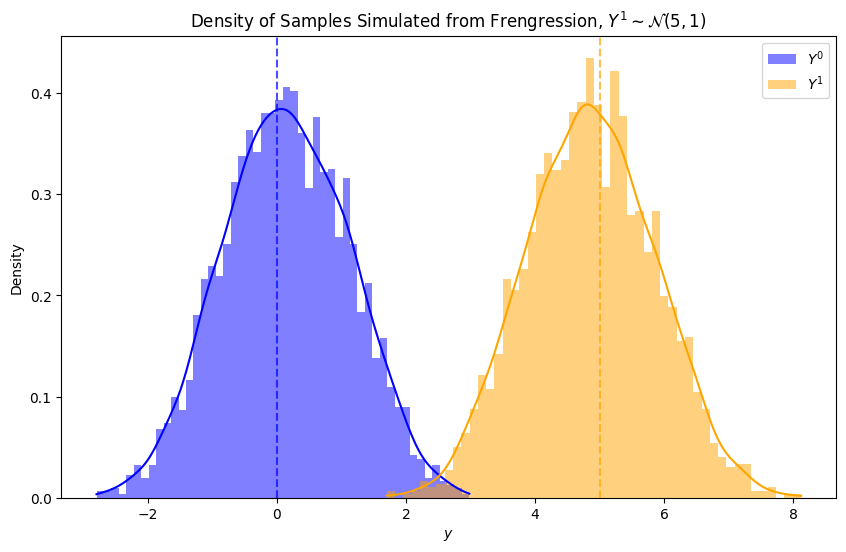

In [12]:
# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(sampled_y_5x[sampled_x_5x==0], kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(sampled_y_5x[sampled_x_5x==1], kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(x=0, color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(x=5, color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title(R"Density of Samples Simulated from Frengression, $Y^1\sim\mathcal{N}(5,1)$")
plt.legend()
plt.show()


In [13]:
margin_module = SpecifiedCausalMargin(ate=0, x_dim = x_tr.shape[1])
model.specify_causal(causal_margin=margin_module)
# model.train_y(x_tr, z_tr, y_tr, num_iters=100000, lr=1e-4, print_every_iter=1000)
sampled_x_0x,sampled_y_0x,sampled_z_0x = model.sample_joint(sample_size=5000)
print('Diff-in-means: ', sampled_y_0x[sampled_x_0x==1].mean()-sampled_y_0x[sampled_x_0x==0].mean())
print('Proportion of sampled treated: ', (sampled_x_0x==1).sum()/sampled_x_0x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(-0.2637)
Proportion of sampled treated:  tensor(0.4582)
Proportion of true treated:  tensor(0.4958)


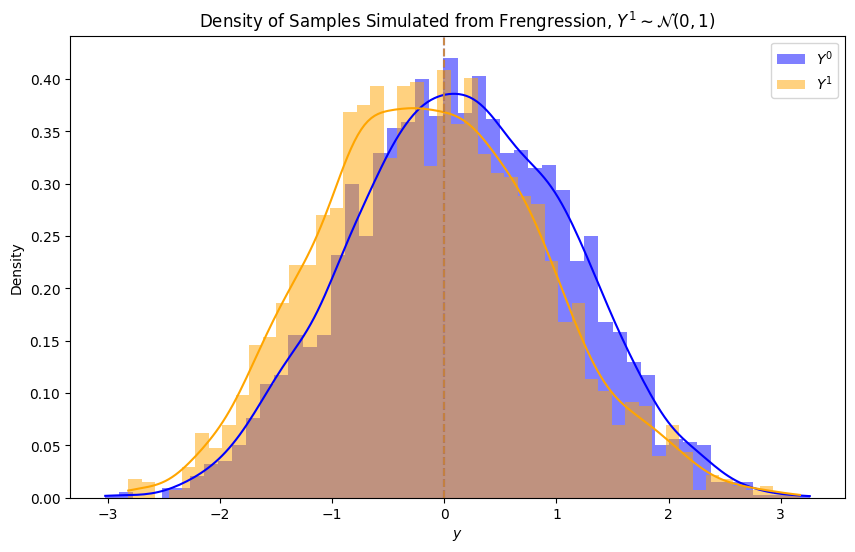

In [14]:
# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(sampled_y_0x[sampled_x_0x==0], kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(sampled_y_0x[sampled_x_0x==1], kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(x=0, color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(x=0, color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title(R"Density of Samples Simulated from Frengression, $Y^1\sim\mathcal{N}(0,1)$")
plt.legend()
plt.show()


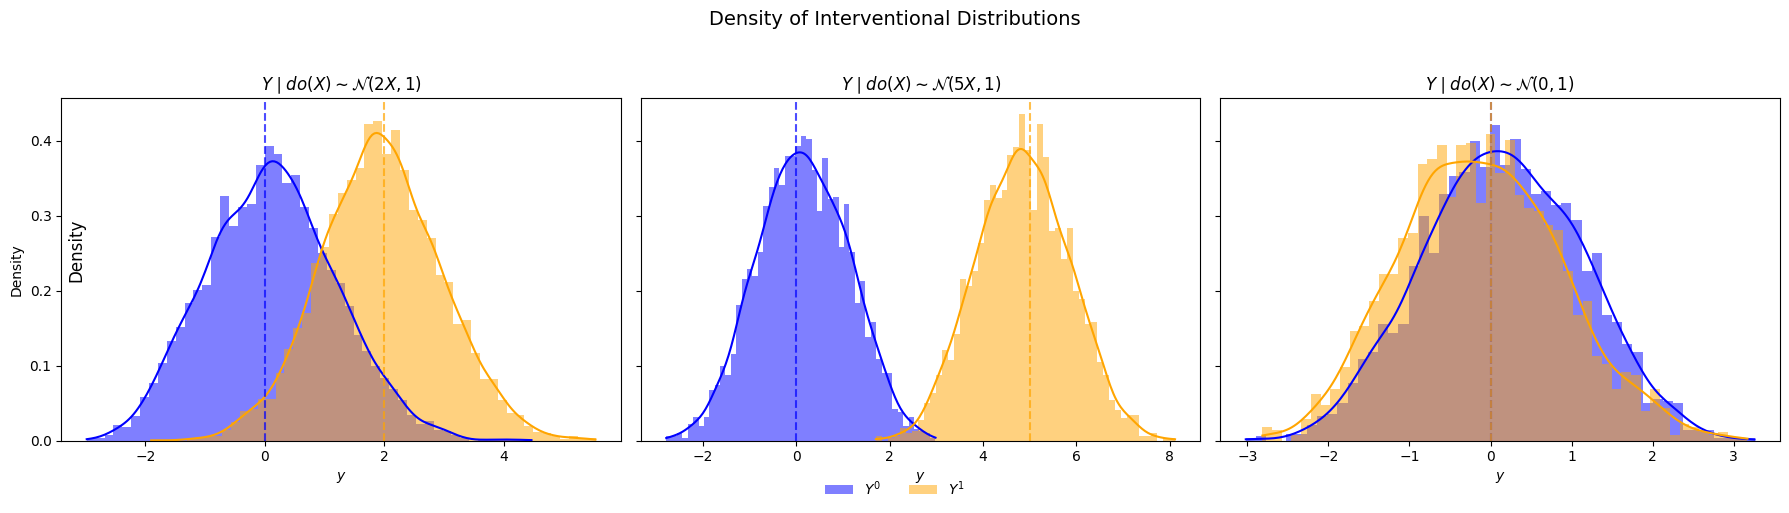

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# assume x0_samples, x1_samples, sampled_y_5x, sampled_x_5x, sampled_y_0x, sampled_x_0x
# are already in your namespace as from your code above

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# common styling
plot_args = dict(kde=True, stat="density", bins=50, edgecolor=None, alpha=0.5)

# 1) causal margins
sns.histplot(x0_samples, color='blue', label='$Y^0$', ax=axes[0], **plot_args)
sns.histplot(x1_samples, color='orange', label='$Y^1$', ax=axes[0], **plot_args)
axes[0].axvline(0, linestyle='--', color='blue', alpha=0.7)
axes[0].axvline(2, linestyle='--', color='orange', alpha=0.7)
axes[0].set_title("$Y\mid do(X)\sim\mathcal{N}(2X,1)$")
axes[0].set_xlabel("$y$")

# 2) joint sample with ATE=5
sns.histplot(sampled_y_5x[sampled_x_5x==0], color='blue', ax=axes[1], **plot_args)
sns.histplot(sampled_y_5x[sampled_x_5x==1], color='orange', ax=axes[1], **plot_args)
axes[1].axvline(0, linestyle='--', color='blue', alpha=0.7)
axes[1].axvline(5, linestyle='--', color='orange', alpha=0.7)
axes[1].set_title(r"$Y\mid do(X)\sim\mathcal{N}(5X,1)$")
axes[1].set_xlabel("$y$")

# 3) joint sample with ATE=0
sns.histplot(sampled_y_0x[sampled_x_0x==0], color='blue', ax=axes[2], **plot_args)
sns.histplot(sampled_y_0x[sampled_x_0x==1], color='orange', ax=axes[2], **plot_args)
axes[2].axvline(0, linestyle='--', color='blue', alpha=0.7)
axes[2].axvline(0, linestyle='--', color='orange', alpha=0.7)
axes[2].set_title(r"$Y\mid do(X)\sim\mathcal{N}(0,1)$")
axes[2].set_xlabel("$y$")

# share one y-label
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=12)
handles, labels = axes[0].get_legend_handles_labels()
# build a single legend (get handles from the first axis)
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=len(handles),
    frameon=False,
    fontsize=10,
    bbox_to_anchor=(0.5, -0.02)
)

# fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, fontsize=12)
plt.suptitle(R"Density of Interventional Distributions", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space up top for the legend
plt.show()


# With confounding variable

In [55]:
np.random.seed(42)
n_tr = 5000  # Training sample size

nI = 2# Fixed number of instrumental variables
nX = 2
nO = 2
nS = 0
binary_intervention = True
# num_iters = 1500 # Fixed number of training iterations
ate = 4
strength_conf = 2
strength_outcome = 2
strength_insr=2

In [56]:
df_tr = generate_data_causl(n=5000, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)
z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

In [57]:

model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention)
model.train_xz(x_tr, z_tr, num_iters=5000, lr=1e-4, print_every_iter=1000)
model.train_y(x_tr, z_tr, y_tr, num_iters=5000, lr=1e-4, print_every_iter=200,tol=0.001)

Epoch 1: loss 2.2989, loss1 2.4209, loss2 0.2441
Epoch 1000: loss 1.7045, loss1 3.3776, loss2 3.3463
Epoch 2000: loss 1.6944, loss1 3.3732, loss2 3.3575
Epoch 3000: loss 1.7055, loss1 3.3856, loss2 3.3603
Epoch 4000: loss 1.7174, loss1 3.3978, loss2 3.3608
Epoch 5000: loss 1.7112, loss1 3.3895, loss2 3.3565
Epoch 1: loss 3.0943,	loss_y 2.3372, 2.3467, 0.0189,	loss_eta 0.7570, 0.8169, 0.1197
Epoch 200: loss 1.3220,	loss_y 0.7224, 1.2084, 0.9720,	loss_eta 0.5996, 1.3595, 1.5197
Epoch 400: loss 0.8492,	loss_y 0.2716, 0.5784, 0.6135,	loss_eta 0.5776, 1.1228, 1.0904
Epoch 600: loss 0.8095,	loss_y 0.2456, 0.4919, 0.4925,	loss_eta 0.5639, 1.0841, 1.0405
Epoch 800: loss 0.7929,	loss_y 0.2370, 0.4804, 0.4867,	loss_eta 0.5558, 1.0996, 1.0876
Epoch 1000: loss 0.7941,	loss_y 0.2390, 0.4721, 0.4661,	loss_eta 0.5551, 1.1062, 1.1022
Stopping at iter 1186: |Δy|=9.0885e-04, |Δη|=-6.8736e-04


In [58]:
model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=200,tol=0)

Epoch 1: loss 0.7803,	loss_y 0.2260, 0.4639, 0.4758,	loss_eta 0.5544, 1.1187, 1.1286
Epoch 200: loss 0.8143,	loss_y 0.2403, 0.4683, 0.4560,	loss_eta 0.5740, 1.1281, 1.1081
Epoch 400: loss 0.7970,	loss_y 0.2319, 0.4663, 0.4689,	loss_eta 0.5651, 1.1191, 1.1081
Epoch 600: loss 0.8067,	loss_y 0.2258, 0.4643, 0.4770,	loss_eta 0.5809, 1.1365, 1.1113
Epoch 800: loss 0.8122,	loss_y 0.2328, 0.4651, 0.4645,	loss_eta 0.5793, 1.1308, 1.1029
Epoch 1000: loss 0.7945,	loss_y 0.2286, 0.4518, 0.4465,	loss_eta 0.5659, 1.1192, 1.1066


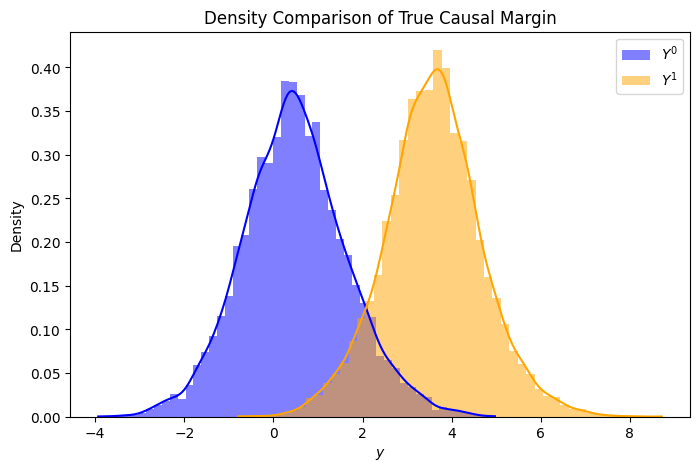

In [59]:
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=10000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=10000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(8, 5))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
# plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
# plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()


In [60]:
model.train_y(x_tr, z_tr, y_tr, num_iters=2000, lr=1e-4, print_every_iter=200,tol=0)

Epoch 1: loss 0.8136,	loss_y 0.2337, 0.4566, 0.4458,	loss_eta 0.5800, 1.1265, 1.0930
Epoch 200: loss 0.7850,	loss_y 0.2171, 0.4504, 0.4665,	loss_eta 0.5679, 1.1179, 1.0999
Epoch 400: loss 0.7892,	loss_y 0.2210, 0.4535, 0.4651,	loss_eta 0.5682, 1.1179, 1.0993
Epoch 600: loss 0.7948,	loss_y 0.2266, 0.4535, 0.4538,	loss_eta 0.5681, 1.1161, 1.0958
Epoch 800: loss 0.7923,	loss_y 0.2258, 0.4493, 0.4471,	loss_eta 0.5665, 1.1178, 1.1025
Epoch 1000: loss 0.7780,	loss_y 0.2207, 0.4501, 0.4587,	loss_eta 0.5573, 1.1125, 1.1103
Epoch 1200: loss 0.7765,	loss_y 0.2273, 0.4487, 0.4428,	loss_eta 0.5491, 1.1044, 1.1106
Epoch 1400: loss 0.7914,	loss_y 0.2212, 0.4455, 0.4486,	loss_eta 0.5702, 1.1167, 1.0931
Epoch 1600: loss 0.7756,	loss_y 0.2194, 0.4479, 0.4571,	loss_eta 0.5562, 1.1214, 1.1304
Epoch 1800: loss 0.7810,	loss_y 0.2205, 0.4454, 0.4497,	loss_eta 0.5605, 1.1175, 1.1140
Epoch 2000: loss 0.7849,	loss_y 0.2210, 0.4426, 0.4431,	loss_eta 0.5639, 1.1091, 1.0905


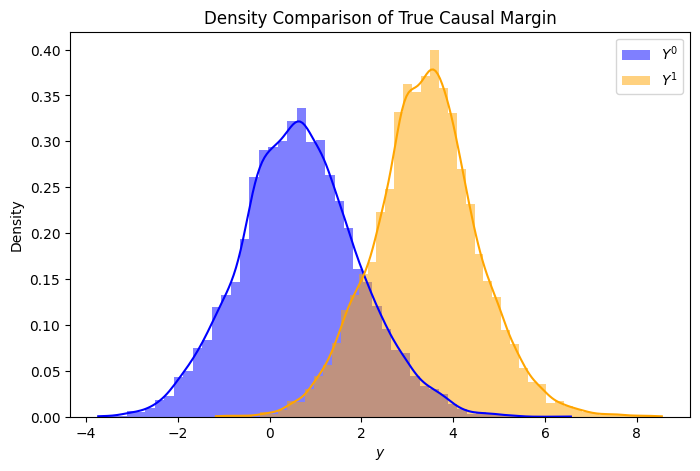

In [61]:
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=10000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=10000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(8, 5))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
# plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
# plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()


In [62]:
model.train_y(x_tr, z_tr, y_tr, num_iters=2000, lr=1e-4, print_every_iter=200,tol=0)

Epoch 1: loss 0.7807,	loss_y 0.2183, 0.4407, 0.4447,	loss_eta 0.5624, 1.1124, 1.1000
Epoch 200: loss 0.7686,	loss_y 0.2207, 0.4395, 0.4375,	loss_eta 0.5479, 1.1052, 1.1146
Epoch 400: loss 0.7868,	loss_y 0.2201, 0.4430, 0.4458,	loss_eta 0.5668, 1.1060, 1.0786
Epoch 600: loss 0.7820,	loss_y 0.2191, 0.4380, 0.4379,	loss_eta 0.5629, 1.1031, 1.0803
Epoch 800: loss 0.7903,	loss_y 0.2190, 0.4431, 0.4481,	loss_eta 0.5712, 1.1192, 1.0959
Epoch 1000: loss 0.7847,	loss_y 0.2232, 0.4382, 0.4299,	loss_eta 0.5615, 1.1153, 1.1077
Epoch 1200: loss 0.7808,	loss_y 0.2185, 0.4353, 0.4337,	loss_eta 0.5624, 1.1178, 1.1108
Epoch 1400: loss 0.7801,	loss_y 0.2168, 0.4269, 0.4202,	loss_eta 0.5632, 1.1147, 1.1028
Epoch 1600: loss 0.7758,	loss_y 0.2165, 0.4273, 0.4214,	loss_eta 0.5593, 1.1073, 1.0961
Epoch 1800: loss 0.7708,	loss_y 0.2097, 0.4287, 0.4379,	loss_eta 0.5610, 1.0973, 1.0725
Epoch 2000: loss 0.7703,	loss_y 0.2122, 0.4296, 0.4349,	loss_eta 0.5581, 1.0990, 1.0817


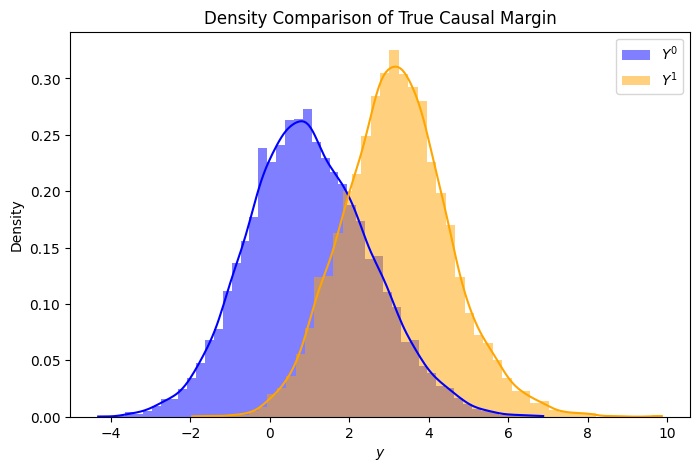

In [63]:
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=10000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=10000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(8, 5))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
# plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
# plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()


Epoch 1: loss 0.7740,	loss_y 0.2143, 0.4335, 0.4384,	loss_eta 0.5597, 1.0995, 1.0796
Epoch 200: loss 0.7779,	loss_y 0.2130, 0.4251, 0.4241,	loss_eta 0.5649, 1.1058, 1.0818
Epoch 400: loss 0.7825,	loss_y 0.2181, 0.4287, 0.4212,	loss_eta 0.5644, 1.1067, 1.0846
Epoch 600: loss 0.7704,	loss_y 0.2124, 0.4233, 0.4217,	loss_eta 0.5579, 1.0975, 1.0792
Epoch 800: loss 0.7756,	loss_y 0.2115, 0.4239, 0.4246,	loss_eta 0.5641, 1.0965, 1.0648
Epoch 1000: loss 0.7777,	loss_y 0.2108, 0.4247, 0.4279,	loss_eta 0.5669, 1.0948, 1.0558
Epoch 1200: loss 0.7796,	loss_y 0.2076, 0.4184, 0.4217,	loss_eta 0.5720, 1.1014, 1.0587
Epoch 1400: loss 0.7626,	loss_y 0.2054, 0.4144, 0.4182,	loss_eta 0.5572, 1.0919, 1.0693
Epoch 1600: loss 0.7809,	loss_y 0.2076, 0.4174, 0.4195,	loss_eta 0.5732, 1.1017, 1.0568
Epoch 1800: loss 0.7852,	loss_y 0.2062, 0.4145, 0.4166,	loss_eta 0.5790, 1.1070, 1.0560
Epoch 2000: loss 0.7659,	loss_y 0.2073, 0.4195, 0.4244,	loss_eta 0.5586, 1.0890, 1.0609


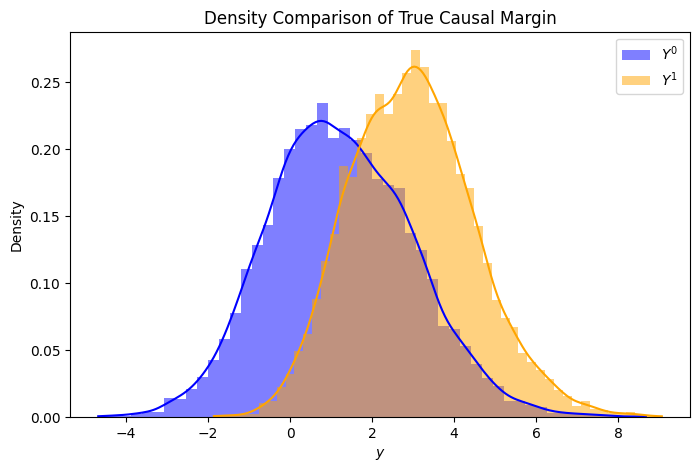

In [64]:
model.train_y(x_tr, z_tr, y_tr, num_iters=2000, lr=1e-4, print_every_iter=200,tol=0)
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=10000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=10000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(8, 5))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
# plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
# plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()


Epoch 1: loss 0.7547,	loss_y 0.1854, 0.3624, 0.3541,	loss_eta 0.5694, 1.0821, 1.0256
Epoch 200: loss 0.7543,	loss_y 0.1798, 0.3598, 0.3602,	loss_eta 0.5746, 1.0723, 0.9955
Epoch 400: loss 0.7389,	loss_y 0.1786, 0.3571, 0.3570,	loss_eta 0.5604, 1.0680, 1.0152
Epoch 600: loss 0.7487,	loss_y 0.1793, 0.3603, 0.3621,	loss_eta 0.5695, 1.0737, 1.0085
Epoch 800: loss 0.7540,	loss_y 0.1846, 0.3634, 0.3575,	loss_eta 0.5694, 1.0790, 1.0193
Epoch 1000: loss 0.7439,	loss_y 0.1801, 0.3602, 0.3600,	loss_eta 0.5637, 1.0668, 1.0062
Epoch 1200: loss 0.7459,	loss_y 0.1795, 0.3536, 0.3481,	loss_eta 0.5664, 1.0722, 1.0116
Epoch 1400: loss 0.7479,	loss_y 0.1811, 0.3541, 0.3461,	loss_eta 0.5668, 1.0735, 1.0135
Epoch 1600: loss 0.7527,	loss_y 0.1768, 0.3540, 0.3545,	loss_eta 0.5759, 1.0830, 1.0143
Epoch 1800: loss 0.7520,	loss_y 0.1750, 0.3504, 0.3509,	loss_eta 0.5770, 1.0782, 1.0024
Epoch 2000: loss 0.7545,	loss_y 0.1793, 0.3526, 0.3466,	loss_eta 0.5752, 1.0732, 0.9960
Epoch 2200: loss 0.7376,	loss_y 0.1740,

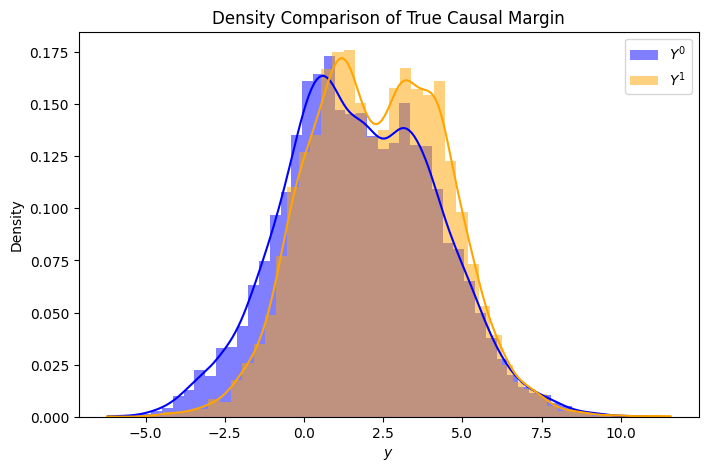

In [67]:
model.train_y(x_tr, z_tr, y_tr, num_iters=5000, lr=1e-4, print_every_iter=200,tol=0)
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=10000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=10000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(8, 5))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
# plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
# plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
# plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
# plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()
